<a href="https://colab.research.google.com/github/tmmunroe/generative-adversarial-networks/blob/main/HW4_COMS4732_Spring23_release.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GANs : Generative Adversarial Networks 


Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. Generative Adversarial Networks. NIPS, 2014. [PDF](https://arxiv.org/pdf/1406.2661v1.pdf)

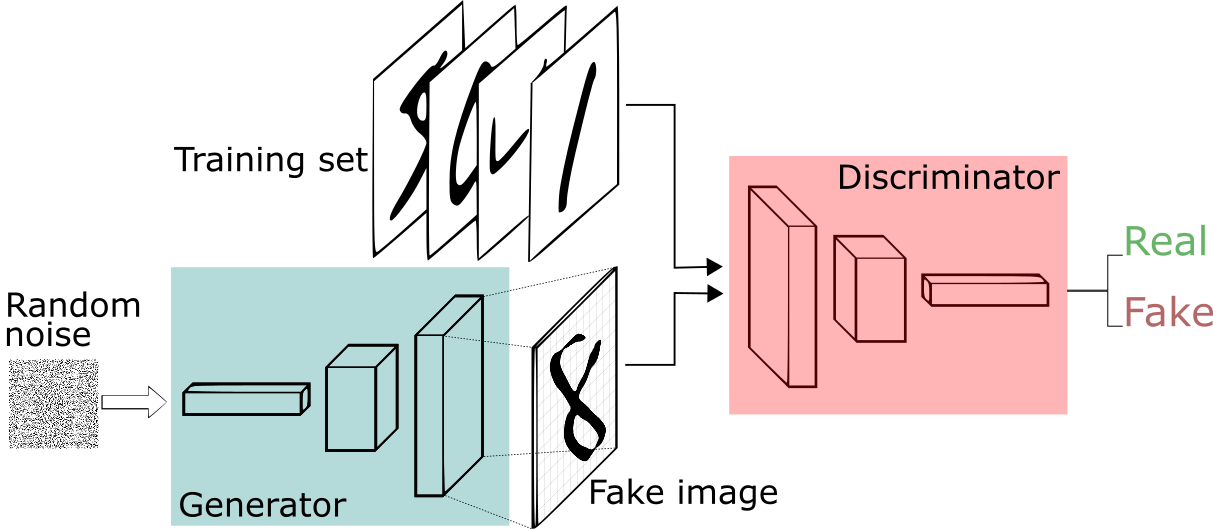

A generative adversarial network (GAN) is a generative model composed of two neural networks: a generator and a discriminator. These two networks are trained in unsupervised way via competition. The generator creates ”realistic” fake images from random noise to fool the discriminator, while the discriminator evaluates the given image for authenticity. 
The loss function that the generator wants to minimize and the discriminator to maximize is as follows: 

min G max D L(D, G) = Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))] 

Here, G and D are the generator and the discriminator. The first and second term of the loss represent the correct prediction of the discriminator on the real images and on the fake images respectively. 




## DCGAN

• You will implement deep convolutional GAN model on the MNIST dataset with Pytorch. The input image size is 28 x 28. 

• The details of the generator of DCGAN is described below. 

• You will start with batch size of 128, input noise of 100 dimension and Adam optimizer with learning rate of 2e-4. You may vary these hyperparameters for better performance. 

## Architectures


Generator: 

The goal for the generator is to use layers such as convolution, maybe also upsampling layer/transposedConvolution to produce image from the given input noise vector. As this is DCGAN (deep convolutional GAN), we expect you to use convolution in the generator. You will get full credit if you can produce `[batchsize, 1, 28, 28]` vector (image) from the given `[batchsize, 100, 1, 1]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.UpsamplingBilinear2d

• torch.nn.ConvTranspose2d

Non-linear layer: 
 
• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Tanh for the last layer's activation. Can you explain why do we need this in the code comment?


You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

We recommend to use 2 Conv/TransposedConv layers. When you are increasing the feature map size, considering upsample the feature by a factor of 2 each time. If you have width of 7 in one of your feature map, to get output with width of 28, you can do upsampling with factor of 2 and upsampling 2 times. 

Discriminator:

You will get full credit if you can produce an output of `[batchsize, 1]` vector (image) from the given input `[batchsize, 1, 28, 28]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.Linear

Non-linear Layers: 

• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Sigmoid for the last layer's activation. Can you explain why do we need this in the code comment?

Use Leaky ReLu as the activation function between all layers, except after the last layer use Sigmoid.

You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

As an example, you may use 2 convolution layer and one linear layer in the discriminator, you can also use other setup. Note that instead of using pooling to downsampling, you may also use stride=2 in convolution to downsample the feature.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# image input size
image_size=28

# Setting up transforms to resize and normalize 
transform=transforms.Compose([
                               transforms.ToTensor(),
                              transforms.Normalize(mean=[0.5], std=[0.5]),
      ## TODO: Normalization for the dataset: data should be in [0,1], so we want values s.t. y = (in - mean)/std 
      # in [-1,1].. 0.5 and 0.5 do this
      ## Normalize the image into [-1,1] range. This is recommended as the tanh function produces output in this range.
                               ])
# batchsize of dataset
batch_size = 100

# Load MNIST Dataset
gan_train_dataset = datasets.MNIST(root='./MNIST/', train=True, transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)




## 1. Model Definition

In [13]:
from scipy.interpolate import InterpolatedUnivariateSpline
class GeneratorBlock(nn.Module):
    def __init__(self, in_chan:int, out_chan:int, kernel_size:int=3, stride:int=1, padding:int=0):
        super(GeneratorBlock,self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_chan, out_chan, kernel_size=kernel_size, stride=stride,
            padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU()

    def forward(self, input):
        return self.relu(self.bn1(self.conv1(input)))

class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()
        # TODO: get kernel dimensions right here.. kernel=3 doesn't seem able to get to 28 no matter what 
        # the stride/padding is
        self.block1 = GeneratorBlock(100, 512, kernel_size=5, stride=2, padding=0)
        self.block2 = GeneratorBlock(512, 256, kernel_size=4, stride=2, padding=0)
        self.block3 = GeneratorBlock(256, 128, kernel_size=3, stride=2, padding=0)
        self.block4 = GeneratorBlock(128, 64, kernel_size=2, stride=1, padding=0)
        self.block5 = GeneratorBlock(64, 32, kernel_size=2, stride=1, padding=0)
        self.convTran1 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=1, padding=0, bias=False)
        self.tanh1 = nn.Tanh()


    def forward(self, input):
        """
        You will get full credit if you can produce 
        input: [batchsize, 100, 1, 1] vector (noise).
        output: [batchsize, 1, 28, 28] vector (image) from the given
        """
        out = self.block1(input)
        # print(out.shape)
        out = self.block2(out)
        # print(out.shape)
        out = self.block3(out)
        # print(out.shape)
        out = self.block4(out)
        # print(out.shape)
        out = self.block5(out)
        # print(out.shape)
        out = self.convTran1(out)
        # print(out.shape)
        out = self.tanh1(out)
        return out

# Code that check size
g=DCGAN_Generator()
batchsize=2
z=torch.zeros((batchsize, 100, 1, 1))
out = g(z)
print(out.size()) # You should expect size [batchsize, 1, 28, 28]
if out.shape != (batchsize, 1, 28, 28):
    raise ValueError('Expected output shape to be ', (batchsize, 1, 28, 28), ' but got ', out.shape)

torch.Size([2, 1, 28, 28])


In [14]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_chan:int, out_chan:int, kernel_size:int=3, padding:int=1, stride:int=1):
        super(DiscriminatorBlock,self).__init__()
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size, padding=padding, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, input):
        return self.lrelu(self.bn1(self.conv1(input)))


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.block1 = DiscriminatorBlock(1, 64, padding=1, stride=2)
        self.block2 = DiscriminatorBlock(64, 128, padding=1, stride=2)
        self.block3 = DiscriminatorBlock(128, 256, padding=1, stride=2)
        self.block4 = DiscriminatorBlock(256, 512, padding=1, stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(512*2*2, 128)
        self.linear2 = nn.Linear(128, 1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self, input):
        """
        input: [batchsize, 1, 28, 28]
        output: [batchsize, 1] vector (image) from the given 
        """
        out = self.block1(input)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.flatten(out)
        out = self.lrelu(self.linear1(out))
        out = self.sigmoid(self.linear2(out))
        return out


d=DCGAN_Discriminator()
x=torch.zeros((batchsize, 1, 28, 28))
out = d(x)
print(out.size()) # You should expect size [batchsize, 1]
if out.shape != (batchsize, 1):
    raise ValueError('Expected output shape to be ', (batchsize, 1), ' but got ', out.shape)


torch.Size([2, 1])


## 2. GAN loss

In [15]:
import torch

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):

    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images (and remember to detach the gradient from the fake images using detach()!)
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''

    real_predictions = D(real)
    real_loss = criterion(real_predictions.view(-1), Valid_label)

    fake_imgs = G(noise)
    fake_predictions = D(fake_imgs.detach())
    generated_loss = criterion(fake_predictions.view(-1), Fake_label)
    
    loss_D = real_loss + generated_loss

    return loss_D, fake_imgs

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    fake_predictions = netD(fake)
    loss_G = criterion(fake_predictions.view(-1), Valid_label)
    
    return loss_G

## 3. Training

In [16]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

from torchsummary import summary
print(summary(netG,(100,1,1)))
print(summary(netD,(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 5, 5]       1,280,000
       BatchNorm2d-2            [-1, 512, 5, 5]           1,024
              ReLU-3            [-1, 512, 5, 5]               0
    GeneratorBlock-4            [-1, 512, 5, 5]               0
   ConvTranspose2d-5          [-1, 256, 12, 12]       2,097,152
       BatchNorm2d-6          [-1, 256, 12, 12]             512
              ReLU-7          [-1, 256, 12, 12]               0
    GeneratorBlock-8          [-1, 256, 12, 12]               0
   ConvTranspose2d-9          [-1, 128, 25, 25]         294,912
      BatchNorm2d-10          [-1, 128, 25, 25]             256
             ReLU-11          [-1, 128, 25, 25]               0
   GeneratorBlock-12          [-1, 128, 25, 25]               0
  ConvTranspose2d-13           [-1, 64, 26, 26]          32,768
      BatchNorm2d-14           [-1, 64,

[0/10][0/600]	Loss_D: 1.4308	Loss_G: 0.9707	
[0/10][50/600]	Loss_D: 2.2085	Loss_G: 0.4908	
[0/10][100/600]	Loss_D: 1.1577	Loss_G: 1.2840	
[0/10][150/600]	Loss_D: 0.9810	Loss_G: 0.8556	
[0/10][200/600]	Loss_D: 1.0524	Loss_G: 0.7102	
[0/10][250/600]	Loss_D: 0.8317	Loss_G: 1.8541	
[0/10][300/600]	Loss_D: 0.8211	Loss_G: 2.2736	
[0/10][350/600]	Loss_D: 1.0333	Loss_G: 1.0832	
[0/10][400/600]	Loss_D: 0.9318	Loss_G: 1.4346	
[0/10][450/600]	Loss_D: 0.6896	Loss_G: 1.4393	
[0/10][500/600]	Loss_D: 1.1873	Loss_G: 3.0757	
[0/10][550/600]	Loss_D: 0.7952	Loss_G: 1.8006	
[1/10][0/600]	Loss_D: 1.0768	Loss_G: 0.8923	
[1/10][50/600]	Loss_D: 1.0661	Loss_G: 1.7758	
[1/10][100/600]	Loss_D: 1.1825	Loss_G: 3.2063	
[1/10][150/600]	Loss_D: 0.8972	Loss_G: 2.7816	
[1/10][200/600]	Loss_D: 1.0105	Loss_G: 1.3760	
[1/10][250/600]	Loss_D: 1.0196	Loss_G: 0.7841	
[1/10][300/600]	Loss_D: 1.0046	Loss_G: 3.7714	
[1/10][350/600]	Loss_D: 1.3150	Loss_G: 2.2912	
[1/10][400/600]	Loss_D: 0.9820	Loss_G: 1.8835	
[1/10][450/600]	Los

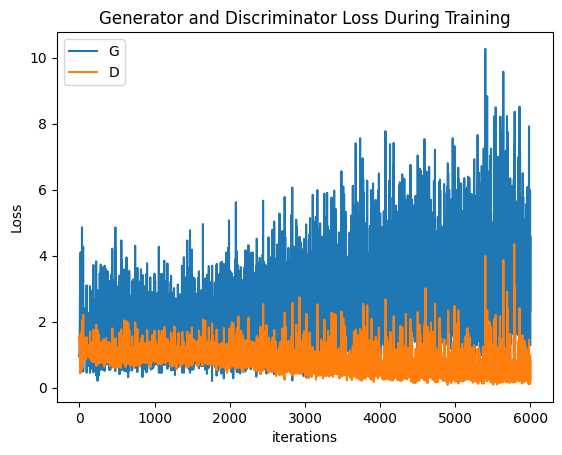

In [17]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.001
beta1 = 0.5

# Setup Adam optimizers for both G and D

################################
# Please fill in your code here:

optimizerD = optim.Adam(netD.parameters(), lr=learning_rate/5, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

################################



img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 10

  
def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        optimizerD.zero_grad()
        loss_D, fake_imgs = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label,
                                    criterion, optimizerD)
        loss_D.backward()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerG.zero_grad()
        loss_G = loss_generator(netD, netG, fake_imgs, Valid_label, criterion, optimizerG)
        loss_G.backward()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))




## 4. Qualitative Visualisations

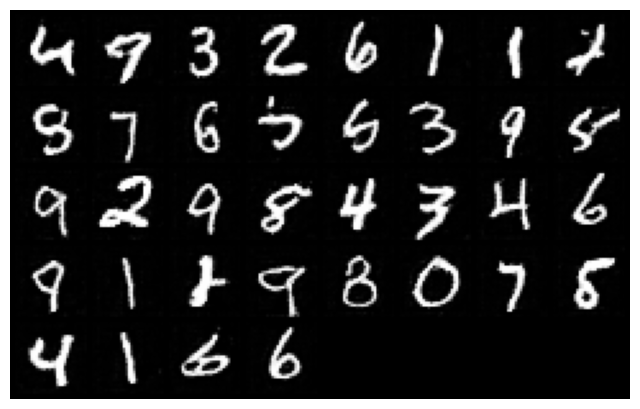

In [18]:
# Test GAN on a random sample and display on 6X6 grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())